# Tutorial 4 - PV Module Performance

Now that we know how to obtain the plane of array (POA) irradiance and cell temperature, let's calculate a module's performance assuming a subset of irradiance and temperature conditions. The objectives for this tutorial are to use pvlib python to do the following:

1. Retrieve a set of module CEC parameters from the latest SAM library.
2. Calculate the single diode parameters for a set of PV module test conditions known as IEC61853.
3. Produce an IV curve for each of the IEC61853 test conditions.
4. Derive the CEC model parameters based on Isc, Voc, Imp, and Vmp CEC measurements.

## STC
The most basic condition is called standard testing conditions or STC, which is considered the reference for most PV modules. For example, all of the PV modules in the SAM CEC module database list their nameplate power at STC.
* irradiance: 1000-W/m&sup2;
* cell temperature: 25&deg;C
* angle of incidence (AOI): 0&deg;
* spectrum: AM1.5g (ASTM G-173)

### Air mass (AM)
The standard refernce AM1.5g (ASTM G-173) is defined as the solar spectrum of global irradiance that passes through 1.5 atmospheres. For more information see [NREL Solar Spectra](https://www.nrel.gov/grid/solar-resource/spectra.html).

## IEC 61853 test conditions
Another common set of test conditions is the IEC 61853 standard which provides a grid of temperatures for module testing that covers the expected range of inicident irradiance and cell temperatures for PV modules assuming that the irradiance is normal and the solar spectrum is similar to AM1.5g.
* irradiance (W/m&sup2;): 100, 200, 400, 600, 800, 1000, 1100
* module temperature (&deg;C): 15, 25, 50, 75
* angle of incidence: 0&deg;
* spectrum: AM1.5g (ASTM G-173)

Certain combinations are excluded because they're unlikely: (1100-W/m&sup2, 15&deg;C), (400-W/m&sup2, 75&deg;C), (200-W/m&sup2, 50&deg;C), (200-W/m&sup2, 75&deg;C), (100-W/m&sup2, 50&deg;C), and (100-W/m&sup2, 75&deg;C)

In [1]:
# import pvlib and other useful python packages
import pvlib
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
# set STC reference conditions
E0 = 1000  # W/m^2
T0 = 25  # degC

# set the IEC61853 test matrix
T_IEC61853 = [15, 25, 50, 75]
E_IEC61853 = [100, 200, 400, 600, 800, 1000, 1100]
IEC61853 = np.meshgrid(T_IEC61853, E_IEC61853)

# Single Diode Model (SDM) & IV Curve
PV module performance can be modeled using point or continuous IV-curve models. Point models like PVWatts and The Sandia Array Performance Model (SAPM, _aka_ King model) yield the current (I), voltage (V), and power (P) at a single or discrete set of points. PVWatts only yields the performance at the max power point (MPP) of the module, whereas the SAPM also yields the short circuit current (Isc), open circuit voltage (Voc).

Continuous IV curve models like the CEC, PVsyst, and DeSoto models yield a relation between current and voltage called an IV curve, and therefore yield a continuous set of (I, V) points spanning from Isc to Voc and beyond. The domain of the IV curve is in quadrants 1, 2, and 4 where voltage is on the horizontal and current is on the vertical axis.

[![IV curve](https://www.pveducation.org/sites/default/files/PVCDROM/Modules/Images/NONIDEAL.gif)](https://www.pveducation.org/pvcdrom/modules-and-arrays/mismatch-effects)

Attribution: [PV Education, UNSW, ASU, _et al._](https://www.pveducation.org/pvcdrom/modules-and-arrays/mismatch-effects)

The IV curve relationship is based on an electrical analog called the single diode model which is defined by 5 parameters: the light current (IL), shunt resistance (Rsh), series resistance (Rs), diode saturation current (Isat or Io), and the diode ideality factor (a). Other symbols for diode ideality factor are (&gamma;) and (n), but (&gamma;) is also used for power temperature coefficient.

[![single diode model](https://pvpmc.sandia.gov/wp-content/uploads/2012/04/Single-Diode-EC2.png)](https://pvpmc.sandia.gov/modeling-steps/2-dc-module-iv/diode-equivalent-circuit-models/)

Attribution: [Sandia NL PV Performance Modeling Collaborative](https://pvpmc.sandia.gov/modeling-steps/2-dc-module-iv/diode-equivalent-circuit-models/)

## CEC Model (_aka_ SAM or 6-parameter model)
The California Energy Commision (CEC) contracted authorized testing labs to measure at STC the nameplate power (Pmp), Isc, Voc, and the MPP voltage and current (Vmp, Imp), as well as Isc and Voc temperature coefficients, the module dimensions, the number of series cells (Ns), parallel substrings (Np), module area in m&sup2; (Ac), and more. Tables of the CEC module parameters are available from the [Solar Equipment Lists](https://www.energy.ca.gov/programs-and-topics/programs/solar-equipment-lists). These measurements have been fit to the SDM by the NREL System Advisor Model (SAM) and stored in a CSV file that is bundled with SAM. You can access the [SAM library on GitHub](https://github.com/NREL/SAM/tree/develop/deploy/libraries). This SAM library of module coefficients derived from the CEC measurements are collectively called CEC modules and the SAM model that uses the derived SDM coefficients is called the CEC model. The CEC model used in SAM is sometimes also called the 6-parameter model because of the `Adjust` additional parameter which differentiates it from the DeSoto model.

### pvlib python
There are several functions we can use in pvlib python:

* [`pvlib.pvsystem.retrieve_sam()`](https://pvlib-python.readthedocs.io/en/latest/generated/pvlib.pvsystem.retrieve_sam.html#pvlib.pvsystem.retrieve_sam)
* [`pvlib.pvsystem.calcparam_cec()`](https://pvlib-python.readthedocs.io/en/latest/generated/pvlib.pvsystem.calcparams_cec.html)
* [`pvlib.pvsystem.singlediode()`](https://pvlib-python.readthedocs.io/en/latest/generated/pvlib.pvsystem.singlediode.html)
* [`pvlib.ivtools.sdm.fit_cec_sam()`](https://pvlib-python.readthedocs.io/en/latest/generated/pvlib.ivtools.sdm.fit_cec_sam.html)

In [3]:
# use pvlib python to retrieve CEC module parameters from the SAM libraries
# with the "name" argument set to "CECMod"
CECMODS = pvlib.pvsystem.retrieve_sam(name='CECMod')

# the CEC modules are a pandas DataFrame oriented as columns, transpose to arrange
# as indices
CECMODS.T.head()

,Technology,Bifacial,STC,PTC,A_c,Length,Width,N_s,I_sc_ref,V_oc_ref,...,a_ref,I_L_ref,I_o_ref,R_s,R_sh_ref,Adjust,gamma_r,BIPV,Version,Date
A10Green_Technology_A10J_S72_175,Mono-c-Si,0,175.0914,151.2,1.3,1.576,0.825,72,5.17,43.99,...,1.981696,5.175703,0.0,0.316688,287.102203,16.057121,-0.5072,N,SAM 2018.11.11 r2,1/3/2019
A10Green_Technology_A10J_S72_180,Mono-c-Si,0,179.928,155.7,1.3,1.576,0.825,72,5.31,44.06,...,1.988414,5.316148,0.0,0.299919,259.047943,16.418983,-0.5072,N,SAM 2018.11.11 r2,1/3/2019
A10Green_Technology_A10J_S72_185,Mono-c-Si,0,184.7016,160.2,1.3,1.576,0.825,72,5.43,44.14,...,1.984817,5.435676,0.0,0.311962,298.424438,15.688233,-0.5072,N,SAM 2018.11.11 r2,1/3/2019
A10Green_Technology_A10J_M60_220,Multi-c-Si,0,219.876,189.1,1.624,1.632,0.995,60,7.95,36.06,...,1.673094,7.959062,0.0,0.140393,123.168404,21.875164,-0.5196,N,SAM 2018.11.11 r2,1/3/2019
A10Green_Technology_A10J_M60_225,Multi-c-Si,0,224.9856,193.5,1.624,1.632,0.995,60,8.04,36.24,...,1.671782,8.047206,0.0,0.14737,164.419479,20.698376,-0.5196,N,SAM 2018.11.11 r2,1/3/2019


### CEC modules library
Periodically a static copy of CEC module parametres is copied from the SAM library to pvlib python. The modules are roughly named according the following scheme:

    <manufacturer name> <model name>

Whitesace, dashes, and other non-alphanumerical characters are all replaced by underscores in pvlib python.

EG: "Canadian Solar Inc. CS6X-300M" becomes

    Canadian_Solar_Inc__CS6X_300M

The main CEC module parameters are defined as follows:

* `Technology`: `<str>` one of "Mono-c-Si", "Multi-c-Si", "Thin Film", "CdTe", or "CIGS" families of cells
* `Bifacial`: `<bool>` is bifacial?
* `STC`: `<float>` nameplate in W at STC
* `PTC`: `<float>` nameplate in W at PVUSA test conditions (1-sun, 20&deg; ambient temperature, 1-m/s windspeed)
* `A_c`: `<float>` module area in m&sup2;
* `Length`: `<float>` module length in m;
* `Width`: `<float>` module width in m;
* `N_s`: `<int>` number of cells in series
* `I_sc_ref`: `<float>` short circuit current in A at reference condition 
* `V_oc_ref`: `<float>` open circuit voltage in V at reference condition
* `I_mp_ref`: `<float>` max power current in A at reference condition 
* `V_mp_ref`: `<float>` max power voltage in V at reference condition
* `alpha_sc`: `<float>` short circuit current temperature coefficient in A/&Delta;&deg;C
* `beta_oc`: `<float>` open circuit voltage temperature coefficient in V/&Delta;&deg;C
* `T_NOCT`: `<float>` normal operating cell temperature in &deg;C
* `a_ref`: `<float>` diode ideality factor
* `I_L_ref`: `<float>` light or photogenerated current at reference condition in A
* `I_o_ref`: `<float>` diode saturation current at reference condition in A
* `R_s`: `<float>` series resistance in &Omega;
* `R_sh_ref`: `<float>` shunt resistance at reference condition in &Omega;
* `Adjust`: `<float>` adjustment to short circuit temperature coefficient in %
* `gamma_r`: `<float>` power temperature coefficient at reference condition in %/&Delta;&deg;C
* `BIPV`: `<bool>` is building integrated PV?

In [4]:
# One trick to find the modules is to search the indices using string filters
# For example: find all Candian Solar 220-W mono-Si modules
cs_220m_mods = CECMODS.T.index.str.startswith('Canadian_Solar') & CECMODS.T.index.str.contains('220M')
CECMODS.T[cs_220m_mods]

,Technology,Bifacial,STC,PTC,A_c,Length,Width,N_s,I_sc_ref,V_oc_ref,...,a_ref,I_L_ref,I_o_ref,R_s,R_sh_ref,Adjust,gamma_r,BIPV,Version,Date
Canadian_Solar_Inc__CS5P_220M,Mono-c-Si,0,219.961,200.1,1.7,1.602,1.061,96,5.1,59.4,...,2.635926,5.11426,0.0,1.066023,381.254425,8.619516,-0.476,N,SAM 2018.11.11 r2,1/3/2019
Canadian_Solar_Inc__CS6P_220M,Mono-c-Si,0,219.775,198.5,1.549,1.615,0.959,60,7.97,36.9,...,1.515583,7.980784,0.0,0.397651,293.871094,-3.311191,-0.436,N,SAM 2018.11.11 r2,1/3/2019


In [5]:
# that was almost too easy, let's use the CS5P-220M
# NOTE: don't transpose CECMODS, get column with desired module 
CS_220M = CECMODS['Canadian_Solar_Inc__CS5P_220M']
CS_220M

Technology            Mono-c-Si
Bifacial                      0
STC                     219.961
PTC                       200.1
A_c                         1.7
Length                    1.602
Width                     1.061
N_s                          96
I_sc_ref                    5.1
V_oc_ref                   59.4
I_mp_ref                   4.69
V_mp_ref                   46.9
alpha_sc               0.004539
beta_oc               -0.222156
T_NOCT                     42.4
a_ref                  2.635926
I_L_ref                 5.11426
I_o_ref                     0.0
R_s                    1.066023
R_sh_ref             381.254425
Adjust                 8.619516
gamma_r                  -0.476
BIPV                          N
Version       SAM 2018.11.11 r2
Date                   1/3/2019
Name: Canadian_Solar_Inc__CS5P_220M, dtype: object

## pvfree
Another option to get CEC module parameters is to use [pvfree](https://pvfree.herokuapp.com). You can search the table of the [CEC modules](https://pvfree.herokuapp.com/cec_modules/). Once you find the desired module, you can get a JSON dictionary of the CEC module parameters from the API. For example, [Canadian Solar Inc. CS5P-220M](https://pvfree.herokuapp.com/cec_modules/1733/) can be downloaded from the API here: https://pvfree.herokuapp.com/api/v1/cecmodule/1733/?format=json. You can copy and paste or use python to call the API. The API also has search filters you can use. For example: https://pvfree.herokuapp.com/api/v1/cecmodule/?format=json&Name__istartswith=canadian&STC__gt=219&STC__lt=221 searches for all modules starting with "canadian" and with nameplate between 219-W and 221-W which returns a list of 6 modules in a JSON dictionary.

In [6]:
import urllib, json
params = urllib.parse.urlencode({
    'Name__istartswith': 'canadian',
    'STC__gt': 219, 'STC__lt': 221,
    'I_sc_ref__lt': 6})
with urllib.request.urlopen(f'https://pvfree.herokuapp.com/api/v1/cecmodule/?{params}') as fp:
    cs_220_mods = json.load(fp)
print(f"Total count of Canadian Solar 220-W with Isc < 6A: {cs_220_mods['meta']['total_count']}")
cs_220_mods['objects']

Total count of Canadian Solar 220-W with Isc < 6A: 2


[{'A_c': 1.7,
  'Adjust': 8.619516,
  'BIPV': False,
  'Bifacial': False,
  'Date': '2018-11-04',
  'I_L_ref': 5.11426,
  'I_mp_ref': 4.69,
  'I_o_ref': 8.102508e-10,
  'I_sc_ref': 5.1,
  'Length': 1.602,
  'N_s': 96,
  'Name': 'Canadian Solar Inc. CS5P-220M',
  'PTC': 200.1,
  'R_s': 1.066023,
  'R_sh_ref': 381.254425,
  'STC': 219.961,
  'T_NOCT': 42.4,
  'Technology': 'Mono-c-Si',
  'V_mp_ref': 46.9,
  'V_oc_ref': 59.4,
  'Version': 'SAM 2018.10.29',
  'Width': 1.061,
  'a_ref': 2.635926,
  'alpha_sc': 0.004539,
  'beta_oc': -0.222156,
  'created_on': '2019-02-12',
  'gamma_r': -0.476,
  'id': 1733,
  'modified_on': '2019-02-12',
  'resource_uri': '/api/v1/cecmodule/1733/'},
 {'A_c': 1.639,
  'Adjust': 2.227195,
  'BIPV': False,
  'Bifacial': False,
  'Date': '2018-11-04',
  'I_L_ref': 5.05607,
  'I_mp_ref': 4.73,
  'I_o_ref': 9.957448e-11,
  'I_sc_ref': 5.05,
  'Length': 1.579,
  'N_s': 96,
  'Name': 'Canadian Solar Inc. CS5P-220P',
  'PTC': 193.1,
  'R_s': 1.00467,
  'R_sh_ref': 8

### Pop Quiz #1
Get any CEC module from the `CECMODS` or pvfree.

* Which module did you get?
* How did you get it?
* What is the module's nameplate power, Isc, Voc, Imp, and Vmp?
* Who is the manufacturer?
* What cell technology is it?
* How does it differ from CS5P-220M?

In [7]:
# use this cell to search CECMODS.T or pvfree
your_mod = 'your module goes here'
try:
    your_mod = CECMODS[your_mod]
except KeyError:
    print(f"*** Sorry, '{your_mod}' wasn't found in CECMODS. Please try again. ***")
else:
    # display your module
    your_mod

*** Sorry, 'your module goes here' wasn't found in CECMODS. Please try again. ***


## Calculate CEC Parameters
The module parameters are given at the reference condition. Use [`pvlib.pvsystem.calcparam_cec()`](https://pvlib-python.readthedocs.io/en/latest/generated/pvlib.pvsystem.calcparams_cec.html) to generate the 5 SDM parameters that can be used in with [`pvlib.pvsystem.singlediode()`](https://pvlib-python.readthedocs.io/en/latest/generated/pvlib.pvsystem.singlediode.html) to calculate the IV curve information.

### `nNsVth`, what's this?
The diode ideality factor (n) is combined with the number of cells (Ns) and the thermal voltage (Vth) to create a convenience parameter. This is [syntactic sugar](https://en.wikipedia.org/wiki/Syntactic_sugar).

In [8]:
# finally this is the magic
temp_cell, effective_irradiance = IEC61853
cecparams = pvlib.pvsystem.calcparams_cec(
        effective_irradiance=effective_irradiance,
        temp_cell=temp_cell,
        alpha_sc=CS_220M.alpha_sc,
        a_ref=CS_220M.a_ref,
        I_L_ref=CS_220M.I_L_ref,
        I_o_ref=CS_220M.I_o_ref,
        R_sh_ref=CS_220M.R_sh_ref,
        R_s=CS_220M.R_s,
        Adjust=CS_220M.Adjust,
        EgRef=1.121,
        dEgdT=-0.0002677)
IL, I0, Rs, Rsh, nNsVth = cecparams
# display the photogenerated current
IL

array([[0.50727824, 0.511426  , 0.5217954 , 0.5321648 ],
       [1.01455648, 1.022852  , 1.0435908 , 1.0643296 ],
       [2.02911296, 2.045704  , 2.0871816 , 2.1286592 ],
       [3.04366944, 3.068556  , 3.1307724 , 3.19298881],
       [4.05822592, 4.091408  , 4.1743632 , 4.25731841],
       [5.0727824 , 5.11426   , 5.217954  , 5.32164801],
       [5.58006064, 5.625686  , 5.7397494 , 5.85381281]])

## IV Curve Info
Now that we have the 5 SDM parameters (`IL`, `Io`, `Rs`, `Rsh`, and `nNsVth`) corresponding to each of the test conditions in the IEC61853 test matrix, we can calculate the IV curve information for that irradiance and cell temperature.

In [9]:
# flatten the meshgrid to allow single diode to broadcast the output
curve_info = pvlib.pvsystem.singlediode(
    photocurrent=IL.flatten(),
    saturation_current=I0.flatten(),
    resistance_series=Rs,
    resistance_shunt=Rsh.flatten(),
    nNsVth=nNsVth.flatten(),
    ivcurve_pnts=101,
    method='lambertw')
# display the max power points
curve_info['p_mp']

array([ 22.47343394,  21.33361989,  18.40248885,  15.37301683,
        46.09149166,  43.8742866 ,  38.16845408,  32.26328096,
        93.53042326,  89.21121134,  78.09399194,  66.58417955,
       140.31155148, 133.92211282, 117.4814962 , 100.47025604,
       186.01690382, 177.57186861, 155.8544359 , 133.40606247,
       230.45392244, 219.96093865, 192.99618253, 165.16041729,
       252.16127408, 240.6459279 , 211.06605369, 180.55357125])

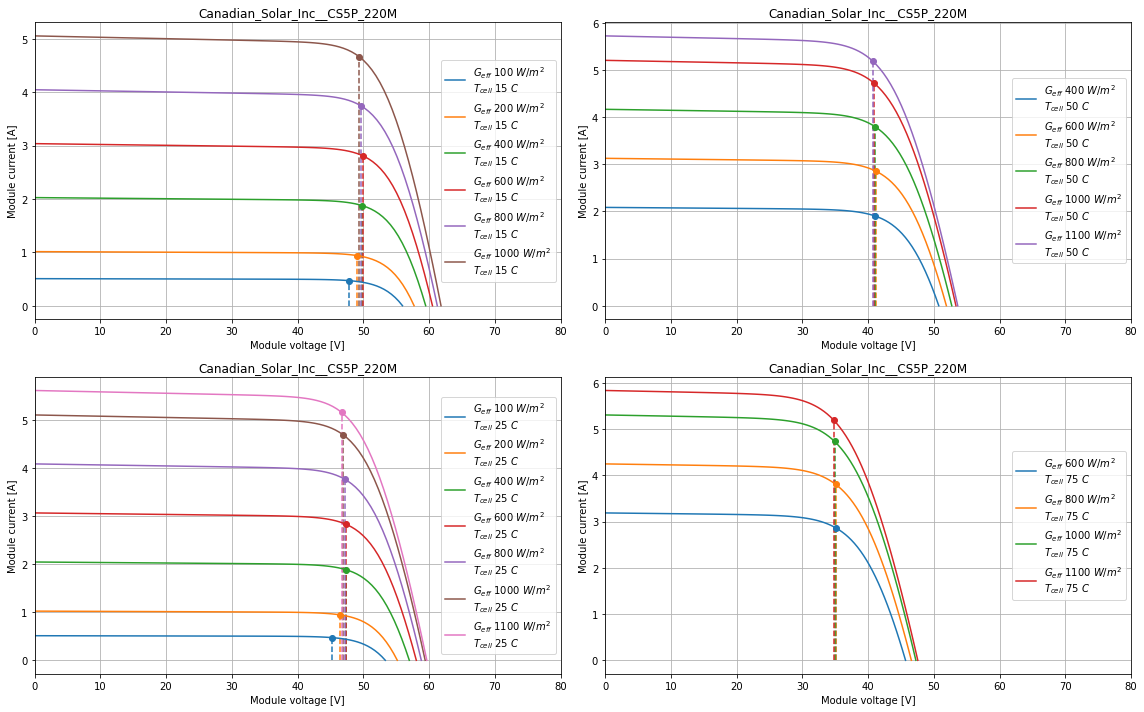

In [10]:
# plot the calculated curves:
exclude = [(1100, 15), (400, 75), (200, 50), (200, 75), (100, 50), (100, 75)]
f, ax = plt.subplots(2, 2, figsize=(16, 10))
for m, irr in enumerate(E_IEC61853):
    for n, tc in enumerate(T_IEC61853):
        if (irr, tc) in exclude:
            continue
        i = n + 4*m
        j = n % 2, n // 2
        label = (
            "$G_{eff}$ " + f"{irr} $W/m^2$\n"
            "$T_{cell}$ " + f"{tc} $C$"
        )
        ax[j].plot(curve_info['v'][i], curve_info['i'][i], label=label)
        kolor = ax[j].lines[-1].get_color()
        v_mp = curve_info['v_mp'][i]
        i_mp = curve_info['i_mp'][i]
        # mark the MPP
        ax[j].plot(v_mp, i_mp, ls='', marker='o', c=kolor)
        ax[j].vlines(v_mp, 0, i_mp, linestyle='dashed', color=kolor)
        # just repeat this every time doesn't hurt anyone
        ax[j].legend(loc='right')
        ax[j].set_xlabel('Module voltage [V]')
        ax[j].set_ylabel('Module current [A]')
        ax[j].set_title(CS_220M.name)
        ax[j].grid(True)
        ax[j].set_xlim([0, 80])

f.set_tight_layout(True)

## Conclusions
So is this what you expected? What do you notice about the relation between voltage and temperature? What about the relation between current and irradiance? What other patterns do you observe